In [2]:
library('devtools')
library('FNN')
library('reshape')
library('ggplot2')
library('gridExtra')
library('ape')
library('MASS')
load_all('SCsim')
load('allsim.20170706.robj')
load('match_params.robj')

Loading SCsim


In [6]:
nevf <- 10
randseed <- 0
ngenes <- 1000
ncells <- 1000
all_alphas <- seq(0.05,0.15,0.01)
nbins <- 10
effect_nonzero <- 0.3
effect_sd <- 1
gene_effects <- GeneEffects(ngenes,nevf,randseed,0.1,effect_sd)

Using  as id variables


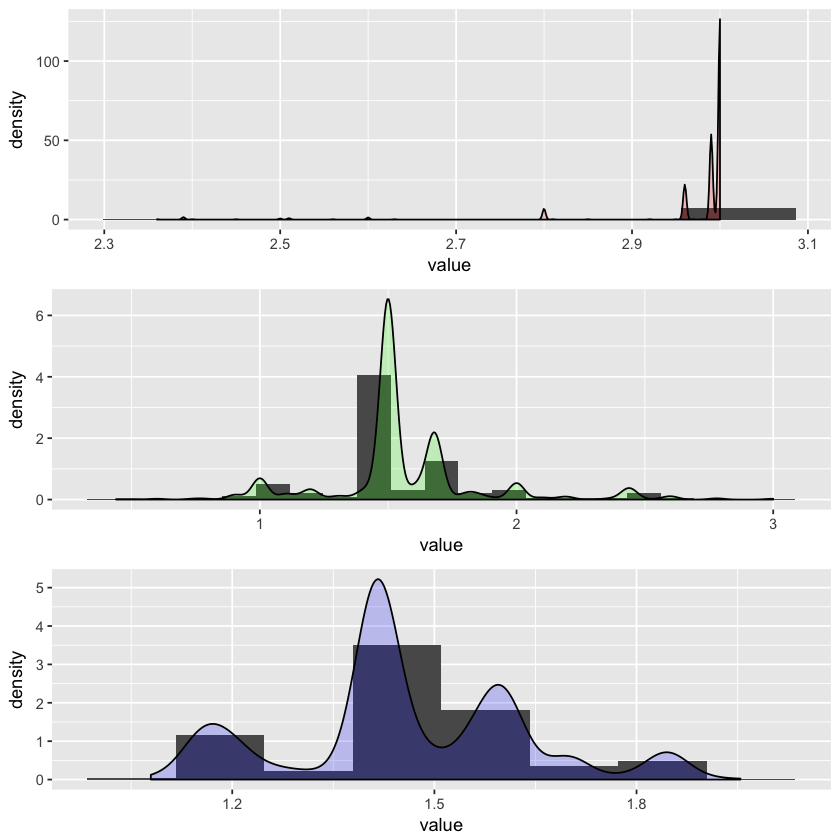

In [10]:
######################## Looking at the effects of evf_sd on parameters###################################################
evf_mean<-rep(0,10);evf_sd<-rep(0.2,10);ncells<-1000
evfs <- lapply(c(1:ncells),function(celli){
	evf <- sapply(c(1:length(evf_mean)),function(evfi){rnorm(1,evf_mean[evfi],evf_sd[evfi])})
	return(evf)
})
params<-lapply(c(1:ncells),function(i){Get_params(gene_effects,evfs[[i]],match_params1,0)})
param1<-do.call(rbind,lapply(params,function(X){X[1,]}))
PlotParamHist(param1,'temp')


In [11]:
########################### The effects of sigma on expression heatmap ###############################################
change_sigma <- lapply(seq(0.1,1,0.1),function(Sigma){
	temp<-sim1Pop1Batch(evf_mean=rep(1,nevf), evf_sd=rep(Sigma,nevf),ncells=ncells,
			randseed=randseed,gene_effects=gene_effects,bimod=0,alpha=0.1,
			alpha_sd=0.01,nbins=10,gcbias=0.5,lenbias=0.3,batch=exp(rnorm(ngenes,0,0.3)),noise=0.1,
			matched_params=match_params1)
	log_count_bins<-seq(0,4,0.4)
	ord1<-PlotCountHeatmap(LogDist(temp[[2]],log_count_bins),rowMeans(temp[[2]]),NA,0.9,paste('truecounts.sigma=',Sigma,'.jpeg'))
	ord2<-PlotCountHeatmap(LogDist(temp[[3]],log_count_bins),rowMeans(temp[[3]]),NA,0.9,paste('droppedcounts.sigma=',Sigma,'.jpeg'))
	ord3<-PlotCountHeatmap(LogDist(temp[[4]],log_count_bins),rowMeans(temp[[4]]),NA,0.9,paste('biasedcounts.sigma=',Sigma,'.jpeg'))
	return(temp)
})

Warning message:
“Removed 2708 rows containing non-finite values (stat_boxplot).”

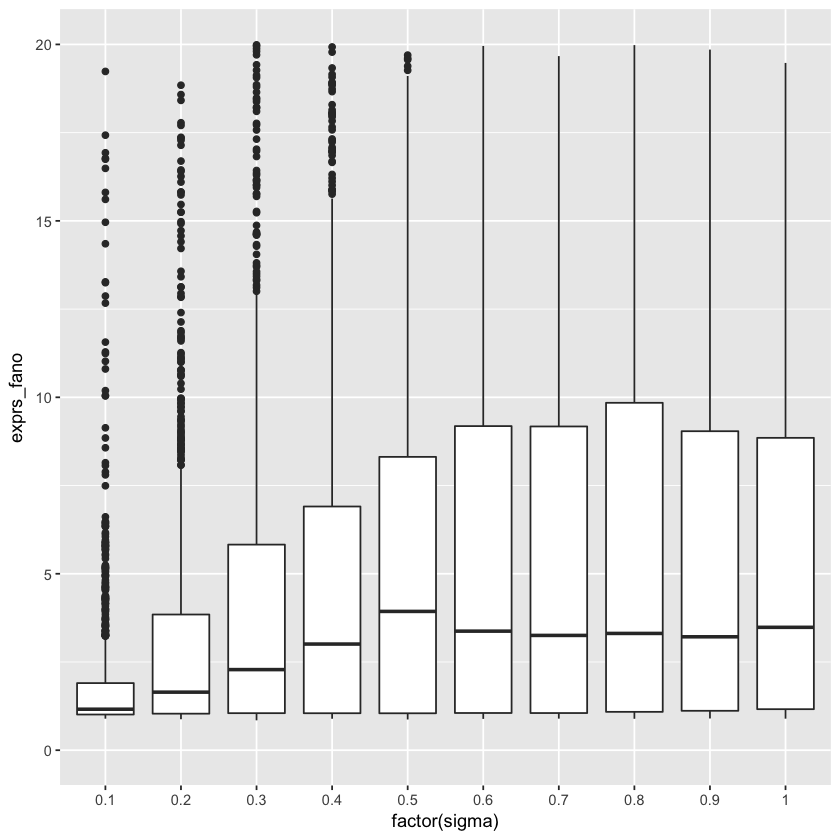

In [12]:
######################### The effects of sigma on expression fano factor ###############################################
fano_compare <- lapply(change_sigma,function(X){apply((X[[2]]),1,function(Y){var(Y)/mean(Y)})})
fano_compare <- do.call(rbind,fano_compare)
rownames(fano_compare)<-seq(0.1,1,0.1)
df<-melt(fano_compare)
colnames(df)=c('sigma','rep','exprs_fano')
p <- ggplot(df, aes(x=factor(sigma), y=exprs_fano))
p <- p + geom_boxplot()+ylim(0,20)
p

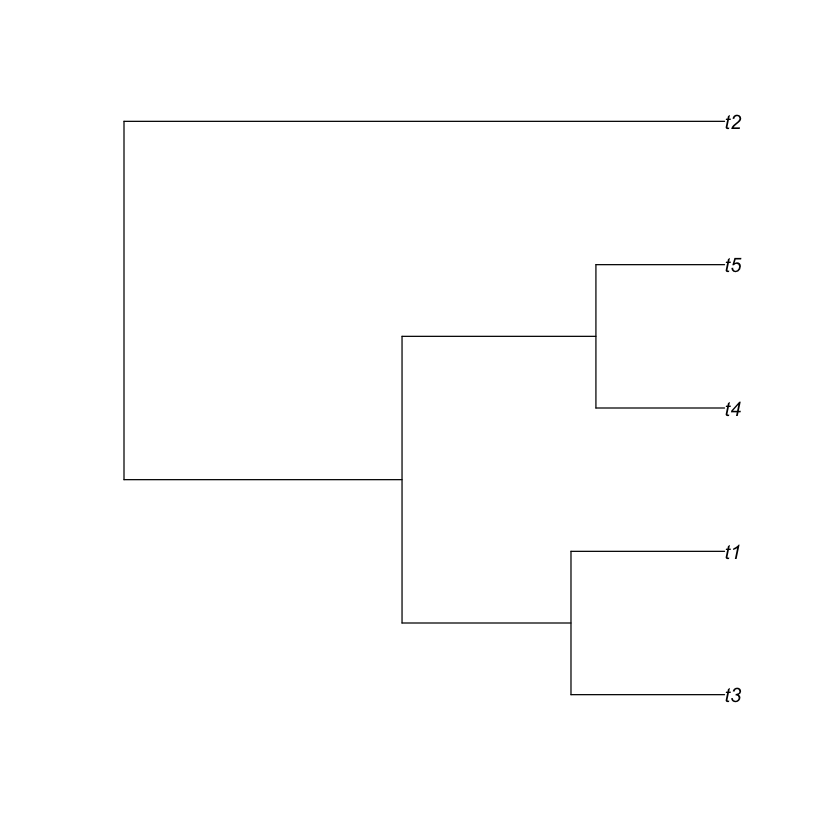

In [4]:
##################### Discrete population #####################
#fist simulate a tree 
phyla<-rcoal(5)
plot(phyla)
PlotTsne <- function(meta,data,plotname,label,discrete=T,saving=F){
	library('Rtsne')
	data_tsne=Rtsne(t(data))
	if(discrete==T){
		plot_tsne=data.frame(alpha=meta[,'alpha'],beta=meta[,'beta'],sigma=meta[,'sigma'],
		pop=meta[,'pop'],label=factor(meta[,label]),x=data_tsne$Y[,1],y=data_tsne$Y[,2])		
	}else{
		plot_tsne=data.frame(alpha=meta[,'alpha'],beta=meta[,'beta'],sigma=meta[,'sigma'],
		pop=meta[,'pop'],label=meta[,label],x=data_tsne$Y[,1],y=data_tsne$Y[,2])
	}
	p <- ggplot(plot_tsne, aes(x, y))
	p <- p + geom_point()
	p <- p + geom_point(aes(colour = plot_tsne[['label']]))+labs(color=label)
	if(saving==T){ggsave(p,filename=plotname,device='jpeg',width=5,height=4)}else{p}
	return(plot_tsne)
}

In [ ]:
result <- Npop1Batch(phyla=phyla,nevf=10,
	evf_sd=0.1, ncells=rep(100,5),
	randseed=0,gene_effects=gene_effects,bimod=0,alpha=0.1,
	alpha_sd=0.05,nbins=10,gcbias=0.1,lenbias=0.1,batch=1, noise=0.1)

tsne <- PlotTsne(result[[2]],data=result[[1]][[3]],label='pop',plotname='')


Warning message in rbinom(n = 1, size = Y, prob = alphas[i]):
“NAs produced”Warning message in rbinom(n = 1, size = Y, prob = alphas[i]):
“NAs produced”Warning message in rbinom(n = 1, size = Y, prob = alphas[i]):
“NAs produced”Warning message in rbinom(n = 1, size = Y, prob = alphas[i]):
“NAs produced”Warning message in rbinom(n = 1, size = Y, prob = alphas[i]):
“NAs produced”Warning message in rbinom(n = 1, size = Y, prob = alphas[i]):
“NAs produced”Warning message in rbinom(n = 1, size = Y, prob = alphas[i]):
“NAs produced”Warning message in rbinom(n = 1, size = Y, prob = alphas[i]):
“NAs produced”Warning message in rbinom(n = 1, size = Y, prob = alphas[i]):
“NAs produced”Warning message in rbinom(n = 1, size = Y, prob = alphas[i]):
“NAs produced”Warning message in rbinom(n = 1, size = Y, prob = alphas[i]):
“NAs produced”Warning message in rbinom(n = 1, size = Y, prob = alphas[i]):
“NAs produced”Warning message in rbinom(n = 1, size = Y, prob = alphas[i]):
“NAs produced”Warning mess

In [ ]:

NpopNBatch(phyla,nevf=10,nbatches=3,
	evf_sd=0.1,ncells=matrix(rep(10,30),nrow=3),
	randsee=0,gene_effects=gene_effects,bimod=0,alpha=rep(0.1,3),
	alpha_sd=rep(0.01,3),nbins=10,gcbias=rep(0.1,3),lenbias=rep(0.1,3),
	batch=rep(0.1,3),noise=rep(0.05,3))



######################## Looking at the effects of bimod on parameters###################################################
lapply(seq(0,1,0.05),function(bimod){
	evf_mean<-rep(0,10);evf_sd<-rep(0.5,10);ncells<-1000
	evfs <- lapply(c(1:ncells),function(celli){
		evf <- sapply(c(1:length(evf_mean)),function(evfi){rnorm(1,evf_mean[evfi],evf_sd[evfi])})
		return(evf)
	})
	params<-lapply(c(1:ncells),function(i){Get_params(gene_effects,evfs[[i]],match_params1,bimod)})
	param1<-do.call(rbind,lapply(params,function(X){X[1,]}))
	PlotParamHist(param1,paste('beta=',bimod,'.1',sep=''))
	param2<-do.call(rbind,lapply(params,function(X){X[2,]}))
	PlotParamHist(param2,paste('beta=',bimod,'.2',sep=''))
})
########################### The effects of bimod on expression heatmap ###############################################
change_bimod<-lapply(seq(0,1,0.05),function(bimod){
	temp<-sim1Pop1Batch(evf_mean=rep(1,nevf), evf_sd=rep(0.2,nevf),ncells=ncells,
			randseed=randseed,gene_effects=gene_effects,bimod=bimod,alpha=0.1,
			alpha_sd=0.01,nbins=10,gcbias=0.5,lenbias=0.3,batch=exp(rnorm(ngenes,0,0.3)),noise=0.1,
			matched_params=match_params1)
	log_count_bins<-seq(0,4,0.4)
	ord1<-PlotCountHeatmap(LogDist(temp[[2]],log_count_bins),rowMeans(temp[[2]]),NA,1,paste('truecounts.bimod=',bimod,'.jpeg',sep=''))
	ord2<-PlotCountHeatmap(LogDist(temp[[3]],log_count_bins),rowMeans(temp[[3]]),NA,1,paste('droppedcounts.bimod=',bimod,'.jpeg',sep=''))
	ord3<-PlotCountHeatmap(LogDist(temp[[4]],log_count_bins),rowMeans(temp[[4]]),NA,1,paste('biasedcounts.bimod=',bimod,'.jpeg',sep=''))
	return(temp)
})
######################### The effects of bimod on expression fano factor ###############################################
fano_compare <- lapply(change_bimod,function(X){apply((X[[2]]),1,function(Y){var(Y)/mean(Y)})})
fano_compare <- do.call(rbind,fano_compare)
rownames(fano_compare)<-seq(0,1,0.05)
df<-melt(fano_compare)
colnames(df)=c('beta','rep','exprs_fano')
p <- ggplot(df, aes(x=factor(beta), y=exprs_fano))
p <- p + geom_boxplot()+ylim(0,20)
ggsave(p,file='temp.jpeg')
######################### The effects of alpha on clustering ###############################################
ncells <- 100
ngenes <- 1000
start <- proc.time()
npop=3
phyla<-rcoal(3)
plot(phyla)
cor_evf_mean<-vcv.phylo(phyla,cor=T)
pop_evf_mean<-mvrnorm(nevf,rep(0,npop),cor_evf_mean)

change_alphas<-lapply(seq(0.05,0.15,0.01),function(Alpha){
	start<-proc.time()
	pop_change <- lapply(c(1:npop),function(pop){
		evf_mean <- pop_evf_mean[,pop]
		sim1Pop1Batch(evf_mean=evf_mean, evf_sd=rep(0.1,nevf),ncells=ncells,
			randseed=randseed,gene_effects=gene_effects,bimod=0,alpha=Alpha,
			alpha_sd=0.01,nbins=10,gcbias=0.5,lenbias=0.3,batch=1,noise=0.1)
	})
	proc_time <- proc.time() - start
	ncells <- length(all_counts[1,])
	meta <- data.frame(beta=rep(1,ncells),sigma=rep(0,ncells),alpha=rep(0.1,ncells),
		pop=do.call(c,lapply(c(1:npop),function(x){rep(x,100)})))
	for(type in c(1:3)){	
		all_counts<-do.call(cbind,lapply(pop_change,function(X){X[[type+1]][,c(1:100)]}))
		result <- PlotTsne(meta,data=all_counts,label='pop',plotname=paste('alpha_change.',type,'.alpha=',Alpha,'.jpg',sep=''))
	}	
	return(list(pop_change,meta))
})
######################### The effects of alpha on expression mean and fano factor ###############################################
#check that mean is different
mean_compare <- lapply(change_alphas,function(X){
	sapply(X[[1]],function(Y){mean(Y[[3]])})
})
mean_compare <- do.call(rbind,mean_compare)

#check correlation with real counts with different alpha (correlation increases with )
cor_compare <- lapply(change_alphas,function(X){
	sapply(X[[1]],function(Y){mean(cor(Y[[2]],Y[[3]]))})
})
cor_compare <- do.call(rbind,cor_compare)

# average per gene correlations for different alphas 0.8807216 0.8911811 0.8988044 0.9070565 0.9149437
